## Computational Creativity

The following analyzes data gleaned from a Reddit survey (n = 72) regarding how people view Computational Creativity, specifically, how people view computers telling stories. Inferential statistics, data mining, and basic regression are employeed within. 

## Library Management

In [54]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
from scipy import linalg
from apyori import apriori
import mpl_toolkits.mplot3d
from sklearn.linear_model import LinearRegression
from sklearn import svm

%matplotlib inline

## Data Preperation

In [55]:
#Data loading
headers = ["timestamp", "age", "identifications", "filmResponse", "filmPurchase", "gameResponse",
           "gamePurchase", "novelResponse", "novelPurchase", "resultsRequested", "believeInFuture", 
          "hurdlesSeen", "withOrWithout", "realCreativity", "otherThoughts"]

data = pd.read_csv("C:/Users/Kyle/Documents/ComputationalCreativitySurvey.csv", names=headers)

In [56]:
#Drop initial data due to form uncertainty
for x in range(0, 9):
    data = data.drop(x, 0)

In [57]:
data['timestamp'].describe()

count                            72
unique                           72
top       2020/05/20 4:00:31 PM EST
freq                              1
Name: timestamp, dtype: object

In [58]:
#One-hot encoding
data['fictionWriter'] =  data['identifications'].map(lambda x: 1 if x.find('A Fiction Writer') >= 0 else 0)
data['nonfictionWriter'] =  data['identifications'].map(lambda x: 1 if x.find('A Nonfiction Writer') >= 0 else 0)
data['developer'] =  data['identifications'].map(lambda x: 1 if x.find('A Software Developer') >= 0 else 0)
data['dataScientist'] =  data['identifications'].map(lambda x: 1 if x.find('A Data Scientist') >= 0 else 0)
data['gameDesigner'] =  data['identifications'].map(lambda x: 1 if x.find('A Game Designer') >= 0 else 0)
data['musician'] =  data['identifications'].map(lambda x: 1 if x.find('A Musician') >= 0 else 0)
data['filmMaker'] =  data['identifications'].map(lambda x: 1 if x.find('A Filmmaker (Directing/ cinematography/ editing/ acting/ lighting/ etc.)') >= 0 else 0)
data['visualArtist'] =  data['identifications'].map(lambda x: 1 if x.find('A Visual Artist (Non-film-specific: Drawing/ animation/ painting/ etc.)') >= 0 else 0)
data['gamer'] =  data['identifications'].map(lambda x: 1 if x.find('Someone who often plays video games') >= 0 else 0)
data['fictionReader'] =  data['identifications'].map(lambda x: 1 if x.find('Someone who often reads fiction books (On paper/ audiobooks/ ebooks/ etc.)') >= 0 else 0)
data['nonfictionReader'] =  data['identifications'].map(lambda x: 1 if x.find('Someone who often reads nonfiction books (On paper/ audiobooks/ ebooks/ etc)') >= 0 else 0)
data['tvWatcher'] =  data['identifications'].map(lambda x: 1 if x.find('Someone who often watches television') >= 0 else 0)
data['filmViewer'] =  data['identifications'].map(lambda x: 1 if x.find('Someone who often watches movies') >= 0 else 0)

In [59]:
#General typecasting
data["filmResponse"] = pd.to_numeric(data["filmResponse"])
data["gameResponse"] = pd.to_numeric(data["gameResponse"])
data["novelResponse"] = pd.to_numeric(data["novelResponse"])
data["filmPurchase"] = pd.to_numeric(data["filmPurchase"])
data["gamePurchase"] = pd.to_numeric(data["gamePurchase"])
data["novelPurchase"] = pd.to_numeric(data["novelPurchase"])

## Broad Scenario Comparisons

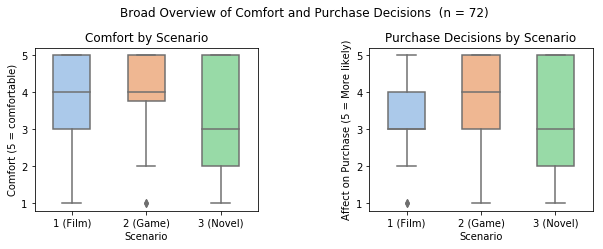

In [61]:
fig = plt.figure(figsize=(10, 3))
fig.subplots_adjust(hspace = 1, wspace = .5)
ax = fig.add_subplot(1, 2, 1)
rawComfort = data[['filmResponse', 'gameResponse', 'novelResponse']].copy()
rawComfort.columns = ['1 (Film)', '2 (Game)', '3 (Novel)']
sns.boxplot(data = rawComfort, width = .5, palette = 'pastel').set(title = 'Comfort by Scenario', xlabel = 'Scenario', ylabel = 'Comfort (5 = comfortable)' )
ax = fig.add_subplot(1, 2, 2)
rawPurchase = data[['filmPurchase', 'gamePurchase', 'novelPurchase']].copy()
rawPurchase.columns = ['1 (Film)', '2 (Game)', '3 (Novel)']
sns.boxplot(data = rawPurchase, width = .5, palette = 'pastel').set(title = 'Purchase Decisions by Scenario', xlabel = 'Scenario', ylabel = 'Affect on Purchase (5 = More likely)' )
plt.suptitle("Broad Overview of Comfort and Purchase Decisions  (n = " + str(rawPurchase.shape[0]) + ')', y = 1.07)
plt.show()

Text(0.5, 0.98, 'Scenario 1 (Film)')

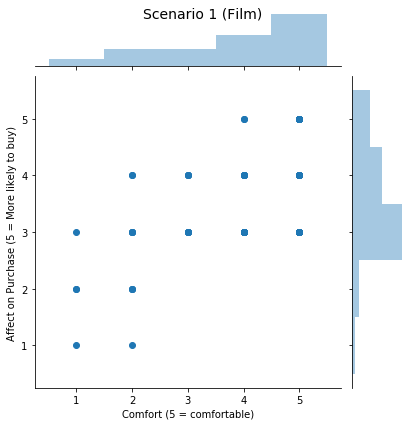

In [62]:
g = sns.jointplot(x="filmResponse", y="filmPurchase", data=data, marginal_kws=dict(bins=np.arange(1, 7) - .5, rug=False)).set_axis_labels('Comfort (5 = comfortable)', 'Affect on Purchase (5 = More likely to buy)')
g.fig.suptitle('Scenario 1 (Film)', fontsize=14)

Text(0.5, 0.98, 'Scenario 2 (Game)')

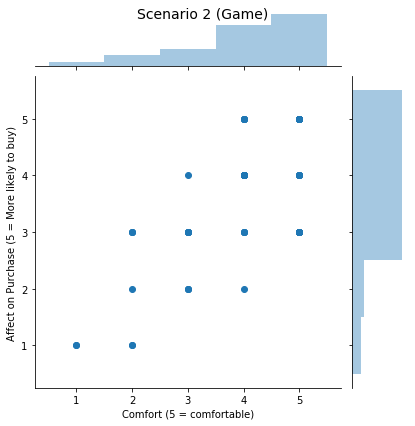

In [63]:
g = sns.jointplot(x="gameResponse", y="gamePurchase", data=data, marginal_kws=dict(bins=np.arange(1, 7) - .5, rug=False)).set_axis_labels('Comfort (5 = comfortable)', 'Affect on Purchase (5 = More likely to buy)')
g.fig.suptitle('Scenario 2 (Game)', fontsize=14)

Text(0.5, 0.98, 'Scenario 3 (Novel)')

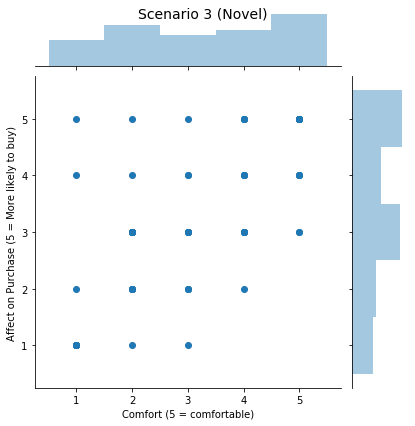

In [64]:
g = sns.jointplot(x="novelResponse", y="novelPurchase", data=data, marginal_kws=dict(bins=np.arange(1, 7) - .5, rug=False)).set_axis_labels('Comfort (5 = comfortable)', 'Affect on Purchase (5 = More likely to buy)')
g.fig.suptitle('Scenario 3 (Novel)', fontsize=14)

In [65]:
#Kruskal-Wallis Testing to determine whether the responses are genuinely different
stats.f_oneway(data['filmResponse'], data['gameResponse'], data['novelResponse'])

F_onewayResult(statistic=7.35876993166287, pvalue=0.000812273521970586)

In [66]:
stats.f_oneway(data['filmPurchase'], data['gamePurchase'], data['novelPurchase'])

F_onewayResult(statistic=1.5106382978723403, pvalue=0.22312462716803697)

## Comparison by Media Usage

In [67]:
readerData = data.loc[data['fictionReader'] == 1]
nonReaderData = data.loc[data['fictionReader'] == 0]
filmViewerData = data.loc[data['filmViewer'] == 1]
nonFilmViewerData = data.loc[data['filmViewer'] == 0]
gamerData = data.loc[data['gamer'] == 1]
nonGamerData = data.loc[data['gamer'] == 0]

In [68]:
readerData.describe()

,filmResponse,filmPurchase,gameResponse,gamePurchase,novelResponse,novelPurchase,fictionWriter,nonfictionWriter,developer,dataScientist,gameDesigner,musician,filmMaker,visualArtist,gamer,fictionReader,nonfictionReader,tvWatcher,filmViewer
count,46.000000,46.000000,46.000000,46.000000,46.000000,46.000000,46.000000,46.000000,46.000000,46.000000,46.000000,46.000000,46.000000,46.000000,46.000000,46.0,46.000000,46.000000,46.000000
mean,3.913043,3.521739,4.021739,3.695652,3.108696,3.282609,0.282609,0.108696,0.391304,0.108696,0.304348,0.195652,0.021739,0.260870,0.847826,1.0,0.369565,0.500000,0.630435
std,1.091911,0.836371,0.881643,1.029985,1.369968,1.276506,0.455243,0.314696,0.493435,0.314696,0.465215,0.401085,0.147442,0.443961,0.363158,0.0,0.488021,0.505525,0.488021
min,2.000000,2.000000,2.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.000000,0.000000,0.000000
25%,3.000000,3.000000,4.000000,3.000000,2.000000,2.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.0,0.000000,0.000000,0.000000
50%,4.000000,3.000000,4.000000,4.000000,3.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.0,0.000000,0.500000,1.000000
75%,5.000000,4.000000,5.000000,4.750000,4.000000,4.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.750000,1.000000,1.0,1.000000,1.000000,1.000000
max,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.000000


In [69]:
nonReaderData.describe()

,filmResponse,filmPurchase,gameResponse,gamePurchase,novelResponse,novelPurchase,fictionWriter,nonfictionWriter,developer,dataScientist,gameDesigner,musician,filmMaker,visualArtist,gamer,fictionReader,nonfictionReader,tvWatcher,filmViewer
count,26.000000,26.000000,26.000000,26.000000,26.000000,26.000000,26.000000,26.000000,26.000000,26.000000,26.000000,26.000000,26.000000,26.000000,26.000000,26.0,26.000000,26.000000,26.000000
mean,3.692308,3.423077,4.038462,3.692308,3.500000,3.500000,0.269231,0.038462,0.461538,0.038462,0.269231,0.153846,0.192308,0.153846,0.769231,0.0,0.153846,0.423077,0.423077
std,1.543223,1.137474,1.370570,1.319674,1.529706,1.529706,0.452344,0.196116,0.508391,0.196116,0.452344,0.367946,0.401918,0.367946,0.429669,0.0,0.367946,0.503831,0.503831
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
25%,2.250000,3.000000,3.250000,3.000000,2.000000,2.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.0,0.000000,0.000000,0.000000
50%,4.000000,3.000000,5.000000,4.000000,4.000000,3.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.0,0.000000,0.000000,0.000000
75%,5.000000,4.000000,5.000000,5.000000,5.000000,5.000000,0.750000,0.000000,1.000000,0.000000,0.750000,0.000000,0.000000,0.000000,1.000000,0.0,0.000000,1.000000,1.000000
max,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,1.000000,1.000000,1.000000


In [70]:
filmViewerData.describe()

,filmResponse,filmPurchase,gameResponse,gamePurchase,novelResponse,novelPurchase,fictionWriter,nonfictionWriter,developer,dataScientist,gameDesigner,musician,filmMaker,visualArtist,gamer,fictionReader,nonfictionReader,tvWatcher,filmViewer
count,40.00000,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,40.00000,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,40.0
mean,3.62500,3.400000,3.975000,3.825000,2.875000,3.175000,0.325000,0.100000,0.37500,0.075000,0.300000,0.200000,0.125000,0.275000,0.900000,0.725000,0.350000,0.750000,1.0
std,1.23387,1.007663,1.073874,1.129727,1.362266,1.356608,0.474342,0.303822,0.49029,0.266747,0.464095,0.405096,0.334932,0.452203,0.303822,0.452203,0.483046,0.438529,0.0
min,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
25%,3.00000,3.000000,3.750000,3.000000,2.000000,2.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.750000,1.0
50%,4.00000,3.000000,4.000000,4.000000,3.000000,3.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.0
75%,5.00000,4.000000,5.000000,5.000000,4.000000,4.000000,1.000000,0.000000,1.00000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0
max,5.00000,5.000000,5.000000,5.000000,5.000000,5.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0


In [71]:
nonFilmViewerData.describe()

,filmResponse,filmPurchase,gameResponse,gamePurchase,novelResponse,novelPurchase,fictionWriter,nonfictionWriter,developer,dataScientist,gameDesigner,musician,filmMaker,visualArtist,gamer,fictionReader,nonfictionReader,tvWatcher,filmViewer
count,32.000000,32.000000,32.000000,32.00000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.0
mean,4.093750,3.593750,4.093750,3.53125,3.718750,3.593750,0.218750,0.062500,0.468750,0.093750,0.281250,0.156250,0.031250,0.156250,0.718750,0.531250,0.218750,0.125000,0.0
std,1.279097,0.874712,1.088336,1.13548,1.396641,1.364513,0.420013,0.245935,0.507007,0.296145,0.456803,0.368902,0.176777,0.368902,0.456803,0.507007,0.420013,0.336011,0.0
min,1.000000,2.000000,1.000000,1.00000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
25%,4.000000,3.000000,3.750000,3.00000,2.750000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
50%,5.000000,3.000000,4.000000,4.00000,4.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.0
75%,5.000000,4.000000,5.000000,4.00000,5.000000,5.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.0
max,5.000000,5.000000,5.000000,5.00000,5.000000,5.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0


In [72]:
gamerData.describe()

,filmResponse,filmPurchase,gameResponse,gamePurchase,novelResponse,novelPurchase,fictionWriter,nonfictionWriter,developer,dataScientist,gameDesigner,musician,filmMaker,visualArtist,gamer,fictionReader,nonfictionReader,tvWatcher,filmViewer
count,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000,59.00000,59.000000,59.000000,59.000000,59.000000,59.000000,59.0,59.000000,59.000000,59.000000,59.000000
mean,3.762712,3.474576,4.067797,3.796610,3.118644,3.322034,0.271186,0.050847,0.40678,0.084746,0.322034,0.152542,0.067797,0.254237,1.0,0.661017,0.322034,0.491525,0.610169
std,1.291070,0.916439,0.997659,1.095125,1.390668,1.318838,0.448388,0.221572,0.49545,0.280894,0.471267,0.362632,0.253555,0.439169,0.0,0.477427,0.471267,0.504219,0.491898
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.000000,0.000000,0.000000,0.000000
25%,3.000000,3.000000,4.000000,3.000000,2.000000,2.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.000000,0.000000,0.000000,0.000000
50%,4.000000,3.000000,4.000000,4.000000,3.000000,3.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,1.000000,0.000000,0.000000,1.000000
75%,5.000000,4.000000,5.000000,5.000000,4.000000,5.000000,1.000000,0.000000,1.00000,0.000000,1.000000,0.000000,0.000000,0.500000,1.0,1.000000,1.000000,1.000000,1.000000
max,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.000000


In [73]:
nonGamerData.describe()

,filmResponse,filmPurchase,gameResponse,gamePurchase,novelResponse,novelPurchase,fictionWriter,nonfictionWriter,developer,dataScientist,gameDesigner,musician,filmMaker,visualArtist,gamer,fictionReader,nonfictionReader,tvWatcher,filmViewer
count,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,13.0,13.000000,13.000000,13.000000,13.000000
mean,4.153846,3.538462,3.846154,3.230769,3.846154,3.538462,0.307692,0.230769,0.461538,0.076923,0.153846,0.307692,0.153846,0.076923,0.0,0.538462,0.153846,0.384615,0.307692
std,1.143544,1.126601,1.405119,1.235168,1.519109,1.613246,0.480384,0.438529,0.518875,0.277350,0.375534,0.480384,0.375534,0.277350,0.0,0.518875,0.375534,0.506370,0.480384
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
25%,4.000000,3.000000,3.000000,3.000000,4.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
50%,4.000000,3.000000,4.000000,3.000000,4.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,1.000000,0.000000,0.000000,0.000000
75%,5.000000,4.000000,5.000000,4.000000,5.000000,5.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.0,1.000000,0.000000,1.000000,1.000000
max,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,1.000000,1.000000,1.000000,1.000000


C:\Users\Kyle\AppData\Roaming\Python\Python35\site-packages\matplotlib\figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


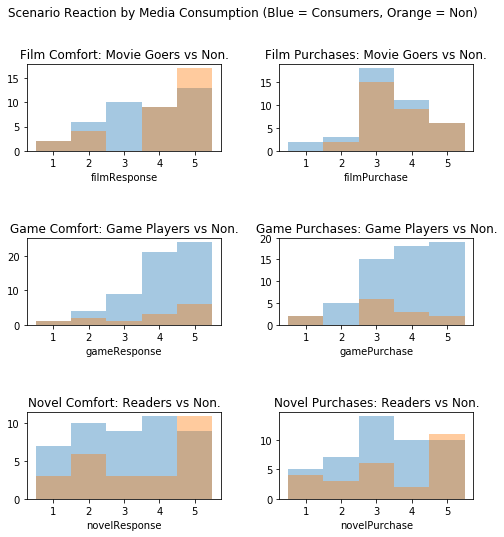

In [74]:
fig = plt.figure(figsize=(8, 8))
fig.subplots_adjust(hspace = 1, wspace = .3)
ax = fig.add_subplot(3, 2, 1)
sns.distplot(filmViewerData["filmResponse"], kde=False, bins=np.arange(1, 7) - .5);
sns.distplot(nonFilmViewerData["filmResponse"], kde=False, bins=np.arange(1, 7) - .5).set_title('Film Comfort: Movie Goers vs Non.')

ax = fig.add_subplot(3, 2, 2)
sns.distplot(filmViewerData["filmPurchase"], kde=False, bins=np.arange(1, 7) - .5);
sns.distplot(nonFilmViewerData["filmPurchase"], kde=False, bins=np.arange(1, 7) - .5).set_title("Film Purchases: Movie Goers vs Non.")

ax = fig.add_subplot(3, 2, 3)
sns.distplot(gamerData["gameResponse"], kde=False, bins=np.arange(1, 7) - .5);
sns.distplot(nonGamerData["gameResponse"], kde=False, bins=np.arange(1, 7) - .5).set_title('Game Comfort: Game Players vs Non.')

ax = fig.add_subplot(3, 2, 4)
sns.distplot(gamerData["gamePurchase"], kde=False, bins=np.arange(1, 7) - .5);
sns.distplot(nonGamerData["gamePurchase"], kde=False, bins=np.arange(1, 7) - .5).set_title("Game Purchases: Game Players vs Non.")

ax = fig.add_subplot(3, 2, 5)
sns.distplot(readerData["novelResponse"], kde=False, bins=np.arange(1, 7) - .5);
sns.distplot(nonReaderData["novelResponse"], kde=False, bins=np.arange(1, 7) - .5).set_title('Novel Comfort: Readers vs Non.')

ax = fig.add_subplot(3, 2, 6)
sns.distplot(readerData["novelPurchase"], kde=False, bins=np.arange(1, 7) - .5);
sns.distplot(nonReaderData["novelPurchase"], kde=False, bins=np.arange(1, 7) - .5).set_title("Novel Purchases: Readers vs Non.")


fig.suptitle("Scenario Reaction by Media Consumption (Blue = Consumers, Orange = Non)")
fig.show()

In [75]:
stats.mannwhitneyu(filmViewerData["filmResponse"], nonFilmViewerData["filmResponse"])

MannwhitneyuResult(statistic=486.0, pvalue=0.0338604742195399)

In [76]:
stats.mannwhitneyu(filmViewerData["filmPurchase"], nonFilmViewerData["filmPurchase"])

MannwhitneyuResult(statistic=584.5, pvalue=0.2529029971109805)

In [77]:
stats.mannwhitneyu(gamerData["gameResponse"], nonGamerData["gameResponse"])

MannwhitneyuResult(statistic=371.5, pvalue=0.42908397094569317)

In [78]:
stats.mannwhitneyu(gamerData["gamePurchase"], nonGamerData["gamePurchase"])

MannwhitneyuResult(statistic=281.0, pvalue=0.06028254286050852)

In [79]:
stats.mannwhitneyu(readerData["novelResponse"], nonReaderData["novelResponse"])

MannwhitneyuResult(statistic=498.0, pvalue=0.11607259155692184)

In [80]:
stats.mannwhitneyu(readerData["novelPurchase"], nonReaderData["novelPurchase"])

MannwhitneyuResult(statistic=533.5, pvalue=0.22006506308028928)

## Technical/ Non-technical Breakdown

In [81]:
def technicalDefinition (row):
    if (row['developer'] == 1 or row['dataScientist'] == 1):
        return 1
    return 0

def artisticDefinition(row):
    if (row['fictionWriter'] == 1 or row['musician'] == 1 or row['filmMaker'] == 1
       or row['visualArtist'] == 1 or row['gameDesigner'] == 1):
        return 1
    return 0

data['technical'] =  data.apply(lambda row: technicalDefinition(row), axis=1)
data['artistic'] =  data.apply(lambda row: artisticDefinition(row), axis=1)

technicalData = data.loc[data['technical'] == 1]
artisticData = data.loc[data['artistic'] == 0]

C:\Users\Kyle\AppData\Roaming\Python\Python35\site-packages\matplotlib\figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


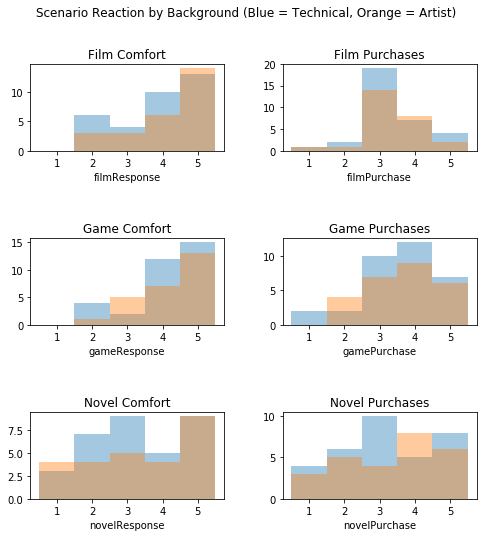

In [82]:
fig = plt.figure(figsize=(8, 8))
fig.subplots_adjust(hspace = 1, wspace = .3)
ax = fig.add_subplot(3, 2, 1)
sns.distplot(technicalData["filmResponse"], kde=False, bins=np.arange(1, 7) - .5);
sns.distplot(artisticData["filmResponse"], kde=False, bins=np.arange(1, 7) - .5).set_title("Film Comfort")

ax = fig.add_subplot(3, 2, 2)
sns.distplot(technicalData["filmPurchase"], kde=False, bins=np.arange(1, 7) - .5);
sns.distplot(artisticData["filmPurchase"], kde=False, bins=np.arange(1, 7) - .5).set_title("Film Purchases")

ax = fig.add_subplot(3, 2, 3)
sns.distplot(technicalData["gameResponse"], kde=False, bins=np.arange(1, 7) - .5);
sns.distplot(artisticData["gameResponse"], kde=False, bins=np.arange(1, 7) - .5).set_title("Game Comfort")

ax = fig.add_subplot(3, 2, 4)
sns.distplot(technicalData["gamePurchase"], kde=False, bins=np.arange(1, 7) - .5);
sns.distplot(artisticData["gamePurchase"], kde=False, bins=np.arange(1, 7) - .5).set_title("Game Purchases")

ax = fig.add_subplot(3, 2, 5)
sns.distplot(technicalData["novelResponse"], kde=False, bins=np.arange(1, 7) - .5);
sns.distplot(artisticData["novelResponse"], kde=False, bins=np.arange(1, 7) - .5).set_title("Novel Comfort")

ax = fig.add_subplot(3, 2, 6)
sns.distplot(technicalData["novelPurchase"], kde=False, bins=np.arange(1, 7) - .5);
sns.distplot(artisticData["novelPurchase"], kde=False, bins=np.arange(1, 7) - .5).set_title("Novel Purchases")

fig.suptitle("Scenario Reaction by Background (Blue = Technical, Orange = Artist)")
fig.show()

In [83]:
stats.mannwhitneyu(technicalData["filmResponse"], artisticData["filmResponse"])

MannwhitneyuResult(statistic=364.0, pvalue=0.14681175258171375)

In [84]:
stats.mannwhitneyu(technicalData["filmPurchase"], artisticData["filmPurchase"])

MannwhitneyuResult(statistic=414.5, pvalue=0.4059990063469681)

In [85]:
stats.mannwhitneyu(technicalData["gameResponse"], artisticData["gameResponse"])

MannwhitneyuResult(statistic=415.5, pvalue=0.4151510787089696)

In [86]:
stats.mannwhitneyu(technicalData["gamePurchase"], artisticData["gamePurchase"])

MannwhitneyuResult(statistic=426.0, pvalue=0.48412404762644223)

In [87]:
stats.mannwhitneyu(technicalData["novelResponse"], artisticData["novelResponse"])

MannwhitneyuResult(statistic=411.0, pvalue=0.3918175237586903)

In [88]:
stats.mannwhitneyu(technicalData["novelPurchase"], artisticData["novelPurchase"])

MannwhitneyuResult(statistic=403.0, pvalue=0.3451481927733645)

## Association Rule Mining

In [89]:
basketData = pd.DataFrame()
basketData['fictionWriter'] = data['fictionWriter'].map(lambda x: 'fictionWriter' if x==1 else '')
basketData['nonfictionWriter'] = data['nonfictionWriter'].map(lambda x: 'nonfictionWriter' if x==1 else '')
basketData['developer'] = data['developer'].map(lambda x: 'developer' if x==1 else '')
basketData['dataScientist'] = data['dataScientist'].map(lambda x: 'dataScientist' if x==1 else '')
basketData['gameDesigner'] = data['gameDesigner'].map(lambda x: 'gameDesigner' if x==1 else '')
basketData['musician'] = data['musician'].map(lambda x: 'musician' if x==1 else '')
basketData['filmMaker'] = data['filmMaker'].map(lambda x: 'filmMaker' if x==1 else '')
basketData['visualArtist'] = data['visualArtist'].map(lambda x: 'visualArtist' if x==1 else '')
basketData['gamer'] = data['gamer'].map(lambda x: 'gamer' if x==1 else '')
basketData['fictionReader'] = data['fictionReader'].map(lambda x: 'fictionReader' if x==1 else '')
basketData['nonfictionReader'] = data['nonfictionReader'].map(lambda x: 'nonfictionReader' if x==1 else '')
basketData['tvWatcher'] = data['tvWatcher'].map(lambda x: 'tvWatcher' if x==1 else '')
basketData['filmViewer'] = data['filmViewer'].map(lambda x: 'filmViewer' if x==1 else '')

def positiveDefinition (row, column):
    if (row[column] == 4 or row[column] == 5):
        return 1
    return 0

def negativeDefinition(row, column):
    if (row[column] == 1 or row[column] == 2):
        return 1
    return 0

basketData['filmComfort'] =  data.apply(lambda row: positiveDefinition(row, 'filmResponse'), axis=1).map(lambda x: 'filmComfort' if x==1 else '')
basketData['gameComfort'] =  data.apply(lambda row: positiveDefinition(row, 'gameResponse'), axis=1).map(lambda x: 'gameComfort' if x==1 else '')
basketData['novelComfort'] =  data.apply(lambda row: positiveDefinition(row, 'novelResponse'), axis=1).map(lambda x: 'novelComfort' if x==1 else '')
basketData['filmDiscomfort'] =  data.apply(lambda row: negativeDefinition(row, 'filmResponse'), axis=1).map(lambda x: 'filmDiscomfort' if x==1 else '')
basketData['gameDiscomfort'] =  data.apply(lambda row: negativeDefinition(row, 'gameResponse'), axis=1).map(lambda x: 'gameDiscomfort' if x==1 else '')
basketData['novelDiscomfort'] =  data.apply(lambda row: negativeDefinition(row, 'novelResponse'), axis=1).map(lambda x: 'novelDiscomfort' if x==1 else '')

basketData['filmBuy'] =  data.apply(lambda row: positiveDefinition(row, 'filmPurchase'), axis=1).map(lambda x: 'filmBuy' if x==1 else '')
basketData['gameBuy'] =  data.apply(lambda row: positiveDefinition(row, 'gamePurchase'), axis=1).map(lambda x: 'gameBuy' if x==1 else '')
basketData['novelBuy'] =  data.apply(lambda row: positiveDefinition(row, 'novelPurchase'), axis=1).map(lambda x: 'novelBuy' if x==1 else '')
basketData['filmPass'] =  data.apply(lambda row: negativeDefinition(row, 'filmPurchase'), axis=1).map(lambda x: 'filmPass' if x==1 else '')
basketData['gamePass'] =  data.apply(lambda row: negativeDefinition(row, 'gamePurchase'), axis=1).map(lambda x: 'gamePass' if x==1 else '')
basketData['novelPass'] =  data.apply(lambda row: negativeDefinition(row, 'novelPurchase'), axis=1).map(lambda x: 'novelPass' if x==1 else '')

In [90]:
basketLists = []
for i in range(0, basketData.shape[0]):
    basketLists.append([str(basketData.values[i,j]) for j in range(0, basketData.shape[1])])

for i in range(0, basketData.shape[0]):
    basketLists[i] = [x for x in basketLists[i] if x]


#print(basketLists)

In [91]:
association_rules = apriori(basketLists, min_support=0.15, min_confidence=0.8, min_lift=2, min_length=2)
association_results = list(association_rules)

In [92]:
print(len(association_results))

33


In [93]:
wantedAntecedent = "novelBuy"

for item in association_results:
    containsTerm = False
    for stat in item[2]:
        if(str(stat[1]).find(wantedAntecedent) >= 0):
            containsTerm = True

    
    if(containsTerm):
        print("Set: " + str([x for x in item[0]]))
        for stat in item[2]:
            antecedent = [x for x in stat[0]]
            consequent = [x for x in stat[1]]
            print("Rule: " + str(antecedent) + " -> " + str(consequent))

        print("Support: " + str(item[1]))
        print("Confidence: " + str(item[2][0][2]))
        print("Lift: " + str(item[2][0][3]))
        print("=====================================")

Set: ['gameBuy', 'novelComfort', 'novelBuy', 'gameComfort']
Rule: ['gameBuy', 'novelComfort'] -> ['novelBuy', 'gameComfort']
Support: 0.25
Confidence: 0.8571428571428571
Lift: 2.2857142857142856
Set: ['gameBuy', 'novelComfort', 'gameComfort', 'filmBuy', 'novelBuy']
Rule: ['gameBuy', 'novelBuy', 'filmBuy'] -> ['novelComfort', 'gameComfort']
Rule: ['gameBuy', 'novelComfort', 'filmBuy'] -> ['novelBuy', 'gameComfort']
Rule: ['gameComfort', 'filmBuy', 'novelBuy'] -> ['gameBuy', 'novelComfort']
Rule: ['novelComfort', 'gameComfort', 'filmBuy'] -> ['gameBuy', 'novelBuy']
Support: 0.18055555555555555
Confidence: 0.9285714285714285
Lift: 2.476190476190476
Set: ['gameBuy', 'novelComfort', 'novelBuy', 'gameComfort', 'filmComfort']
Rule: ['gameBuy', 'novelComfort', 'filmComfort'] -> ['novelBuy', 'gameComfort']
Support: 0.19444444444444445
Confidence: 0.823529411764706
Lift: 2.196078431372549
Set: ['gameBuy', 'novelComfort', 'gamer', 'gameComfort', 'novelBuy']
Rule: ['gameBuy', 'novelComfort', 'game

## Comfort/Purchase Buckets

In [94]:
def comfortScore (row):
    return row['filmResponse'] + row['gameResponse'] + row['novelResponse']

def purchaseScore(row): 
    return row['filmPurchase'] + row['gamePurchase'] + row['novelPurchase']

data['comfortScore'] = data.apply(lambda row: comfortScore(row), axis=1)
data['purchaseScore'] = data.apply(lambda row: purchaseScore(row), axis=1)

Text(0.5, 1.0, 'Comfort Scores: Sum of Comfort Answers')

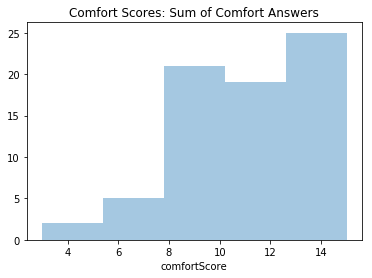

In [95]:
sns.distplot(data["comfortScore"], kde=False).set_title("Comfort Scores: Sum of Comfort Answers")

Text(0.5, 1.0, 'Purchase Scores: Sum of Purchase Answers')

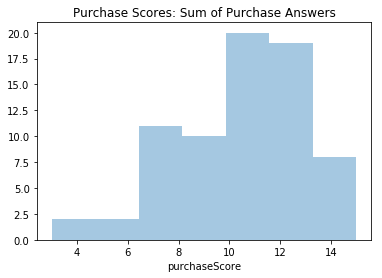

In [96]:
sns.distplot(data["purchaseScore"], kde=False).set_title("Purchase Scores: Sum of Purchase Answers")

C:\Users\Kyle\AppData\Roaming\Python\Python35\site-packages\seaborn\axisgrid.py:1849: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


Text(0.5, 0.98, 'Sum Scores Compared')

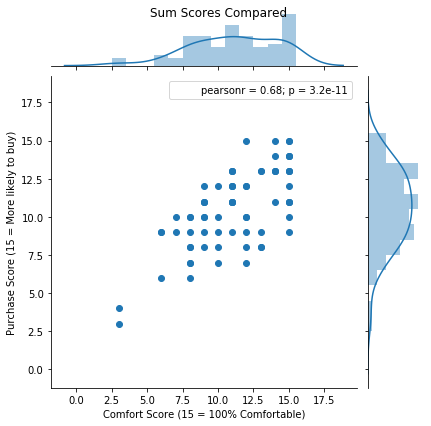

In [112]:
g = sns.jointplot(x="comfortScore", y="purchaseScore",  marginal_kws=dict(kde = True, bins=np.arange(3, 18) - .5), data=data).set_axis_labels('Comfort Score (15 = 100% Comfortable)', 'Purchase Score (15 = More likely to buy)')
g.annotate(stats.pearsonr)
g.fig.suptitle("Sum Scores Compared")

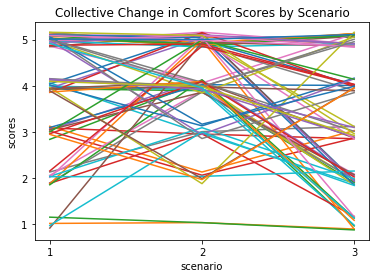

In [113]:
for index, row in data.iterrows():
    tmp = pd.DataFrame()
    scores = [row['filmResponse']+ (np.random.random()-.5)/3, row['gameResponse']+ (np.random.random()-.5)/3, row['novelResponse']+ (np.random.random()-.5)/3]
    tmp['scenario'] = [1, 2, 3]
    tmp['scores'] = scores
    g = sns.lineplot(x='scenario', y='scores', data=tmp)
g.set_title("Collective Change in Comfort Scores by Scenario")
g.set_xticks(np.arange(1, 4, 1.0))
g.set_yticks(np.arange(1, 6, 1.0))

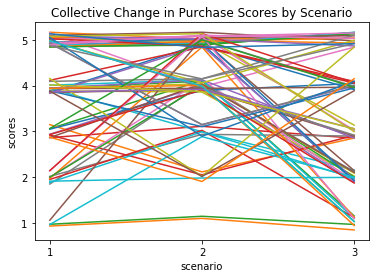

In [114]:
for index, row in data.iterrows():
    tmp = pd.DataFrame()
    scores = [row['filmResponse']+ (np.random.random()-.5)/3, row['gameResponse']+ (np.random.random()-.5)/3, row['novelResponse']+ (np.random.random()-.5)/3]
    tmp['scenario'] = [1, 2, 3]
    tmp['scores'] = scores
    g = sns.lineplot(x='scenario', y='scores', data=tmp)
g.set_title("Collective Change in Purchase Scores by Scenario")
g.set_xticks(np.arange(1, 4, 1.0))
g.set_yticks(np.arange(1, 6, 1.0))

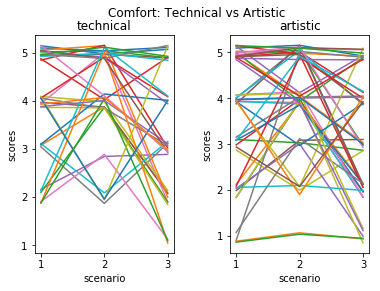

In [100]:
def plotPurchasesIf(val):
    for index, row in data.iterrows():
        if(row[val] == 1):
            tmp = pd.DataFrame()
            scores = [row['filmResponse'] + (np.random.random()-.5)/3, row['gameResponse'] + (np.random.random()-.5)/3, row['novelResponse'] + (np.random.random()-.5)/3]
            tmp['scenario'] = [1, 2, 3]
            tmp['scores'] = scores
            sns.lineplot(x='scenario', y='scores', data=tmp).set_title(val)

def plotResponsesIf(val):
    for index, row in data.iterrows():
        if(row[val] == 1):
            tmp = pd.DataFrame()
            scores = [row['filmResponse'] + (np.random.random()-.5)/3, row['gameResponse'] + (np.random.random()-.5)/3, row['novelResponse'] + (np.random.random()-.5)/3]
            tmp['scenario'] = [1, 2, 3] 
            tmp['scores'] = scores
            sns.lineplot(x='scenario', y='scores', data=tmp).set_title(val)

            
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)
ax = fig.add_subplot(1, 2, 1)
plotResponsesIf('technical')
ax = fig.add_subplot(1, 2, 2)
plotResponsesIf('artistic')
plt.suptitle("Comfort: Technical vs Artistic")
plt.show()

In [101]:
stats.ttest_ind(technicalData['filmResponse'], artisticData['filmResponse'])

Ttest_indResult(statistic=-0.9833044608022986, pvalue=0.3296131093914647)

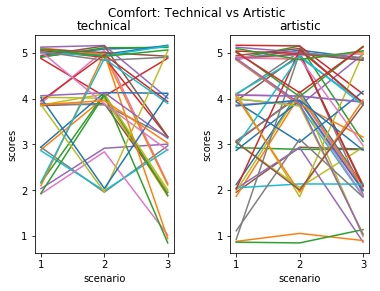

In [102]:
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)
ax = fig.add_subplot(1, 2, 1)
plotPurchasesIf('technical')
ax = fig.add_subplot(1, 2, 2)
plotPurchasesIf('artistic')
plt.suptitle("Comfort: Technical vs Artistic")
plt.show()

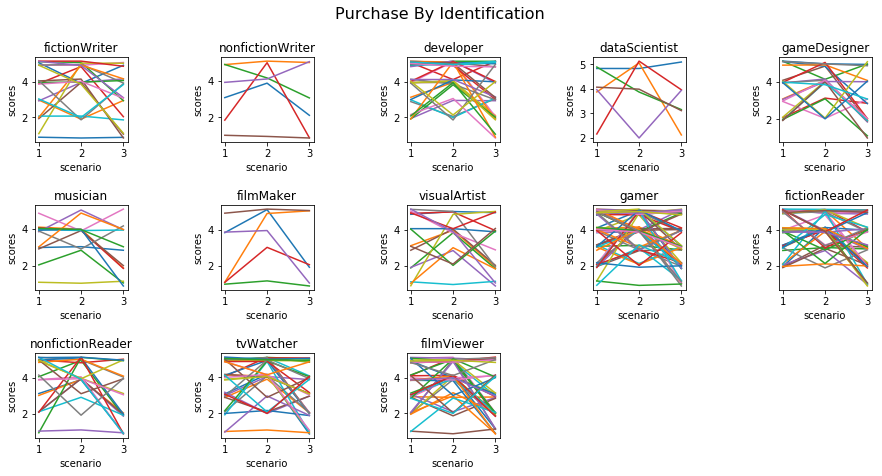

In [103]:
fig = plt.figure( figsize=(15, 7))
fig.subplots_adjust(hspace=.75, wspace=1)
ax = fig.add_subplot(3, 5, 1)
plotPurchasesIf('fictionWriter')
ax = fig.add_subplot(3, 5, 2)
plotPurchasesIf('nonfictionWriter')
ax = fig.add_subplot(3, 5, 3)
plotPurchasesIf('developer')
ax = fig.add_subplot(3, 5, 4)
plotPurchasesIf('dataScientist')
ax = fig.add_subplot(3, 5, 5)
plotPurchasesIf('gameDesigner')
ax = fig.add_subplot(3, 5, 6)
plotPurchasesIf('musician')
ax = fig.add_subplot(3, 5, 7)
plotPurchasesIf('filmMaker')
ax = fig.add_subplot(3, 5, 8)
plotPurchasesIf('visualArtist')
ax = fig.add_subplot(3, 5, 9)
plotPurchasesIf('gamer')
ax = fig.add_subplot(3, 5, 10)
plotPurchasesIf('fictionReader')
ax = fig.add_subplot(3, 5, 11)
plotPurchasesIf('nonfictionReader')
ax = fig.add_subplot(3, 5, 12)
plotPurchasesIf('tvWatcher')
ax = fig.add_subplot(3, 5, 13)
plotPurchasesIf('filmViewer')
plt.suptitle("Purchase By Identification", fontsize=16)
plt.show()

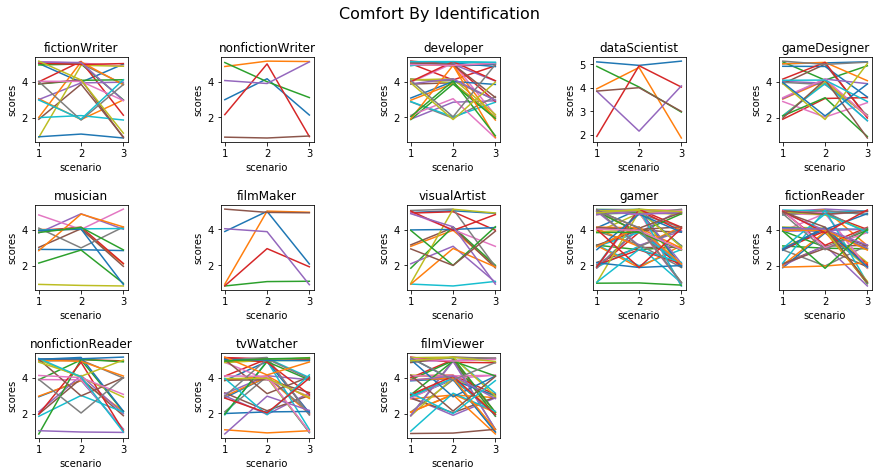

In [104]:
fig = plt.figure( figsize=(15, 7))
fig.subplots_adjust(hspace=.75, wspace=1)
ax = fig.add_subplot(3, 5, 1)
plotResponsesIf('fictionWriter')
ax = fig.add_subplot(3, 5, 2)
plotResponsesIf('nonfictionWriter')
ax = fig.add_subplot(3, 5, 3)
plotResponsesIf('developer')
ax = fig.add_subplot(3, 5, 4)
plotResponsesIf('dataScientist')
ax = fig.add_subplot(3, 5, 5)
plotResponsesIf('gameDesigner')
ax = fig.add_subplot(3, 5, 6)
plotResponsesIf('musician')
ax = fig.add_subplot(3, 5, 7)
plotResponsesIf('filmMaker')
ax = fig.add_subplot(3, 5, 8)
plotResponsesIf('visualArtist')
ax = fig.add_subplot(3, 5, 9)
plotResponsesIf('gamer')
ax = fig.add_subplot(3, 5, 10)
plotResponsesIf('fictionReader')
ax = fig.add_subplot(3, 5, 11)
plotResponsesIf('nonfictionReader')
ax = fig.add_subplot(3, 5, 12)
plotResponsesIf('tvWatcher')
ax = fig.add_subplot(3, 5, 13)
plotResponsesIf('filmViewer')
plt.suptitle("Comfort By Identification", fontsize=16)
plt.show()

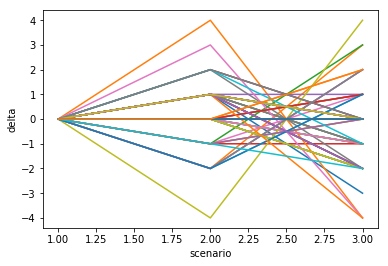

In [105]:
for index, row in data.iterrows():
    tmp = pd.DataFrame()
    scores = [0, row['gamePurchase'] - row['filmPurchase'], row['novelPurchase'] - row['gamePurchase']]
    tmp['scenario'] = [1, 2, 3]
    tmp['delta'] = scores
    sns.lineplot(x='scenario', y='delta', data=tmp)

In [106]:
responseData = pd.DataFrame()
responseData['filmResponse'] = data['filmResponse']
responseData['gameResponse'] = data['gameResponse']
responseData['novelResponse'] = data['novelResponse']
responseData.head()

,filmResponse,gameResponse,novelResponse
9,5,5,5
10,5,5,5
11,3,4,1
12,3,3,3
13,3,4,2


In [107]:
cov_mat = np.cov(responseData.T)

eig_vals, eig_vecs = np.linalg.eig(cov_mat)

# Make a list of (eigenvalue, eigenvector) tuples
eig_pairs = [(np.abs(eig_vals[i]), eig_vecs[:,i]) for i in range(len(eig_vals))]

# Sort the (eigenvalue, eigenvector) tuples from high to low
eig_pairs.sort(key=lambda x: x[0], reverse=True)

print('Eigenvalues in descending order:')
for i in eig_pairs:
    print(i[0])
    
np.cross(eig_pairs[0][1], eig_pairs[1][1])

Eigenvalues in descending order:
3.181491735056803
1.0152545993447077
0.6123303479146105


array([-0.7238952 ,  0.6208199 ,  0.30092923])

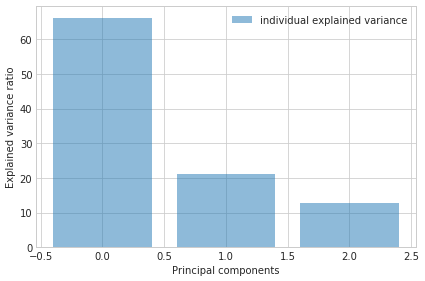

In [108]:
#Calculate and graph explained variance, which measures how much entropy can be attributed to each component.
tot = sum(eig_vals)
var_exp = [(i / tot)*100 for i in sorted(eig_vals, reverse=True)]

with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(6, 4))

    plt.bar(range(3), var_exp, alpha=0.5, align='center', label='individual explained variance')
    plt.ylabel('Explained variance ratio')
    plt.xlabel('Principal components')
    plt.legend(loc='best')
    plt.tight_layout()
plt.show()

In [159]:
regr = LinearRegression()
regressionX = data[['filmResponse', 'gameResponse']].copy()
regressionY = data['novelResponse'].copy()
regr.fit(regressionX, regressionY)
regr.score(regressionX, regressionY)

0.3148739218052423

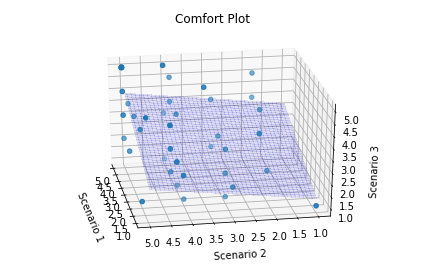

In [166]:
fig = plt.figure()
ax = plt.axes(projection = '3d')
ax.set_title("Comfort Plot")
ax.set_xlabel("Scenario 1", fontsize=10, labelpad = 12)
ax.set_ylabel("Scenario 2 ", fontsize=10, labelpad = 12)
ax.set_zlabel("Scenario 3", fontsize=10, labelpad = 10)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
ax.view_init(29, 170) #Changes viewing angle: Arg1 = Elevation, Arg2 = angle
ax.scatter3D(data['filmResponse'], data['gameResponse'], data['novelResponse'])
ax.dist = 12


X = np.arange(1, 5, 0.05)
Y = np.arange(1, 5, 0.05)
X, Y = np.meshgrid(X, Y)

Z = coef["filmResponse"] * X + coef["gameResponse"] * Y + bterm

surf = ax.plot_surface(X, Y, Z, color = "blue", alpha=.1, linewidth=0, antialiased=False)


fig.tight_layout() 
plt.show()

In [156]:
regr = LinearRegression()
regressionX = data[['filmPurchase', 'gamePurchase']].copy()
regressionY = data['novelPurchase'].copy()
regr.fit(regressionX, regressionY)
regr.score(regressionX, regressionY)

0.25985197918593694

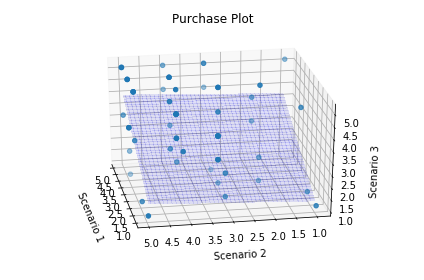

In [157]:
fig = plt.figure()
ax = plt.axes(projection = '3d')
ax.set_title("Purchase Plot")
ax.set_xlabel("Scenario 1", fontsize=10, labelpad = 12)
ax.set_ylabel("Scenario 2 ", fontsize=10, labelpad = 12)
ax.set_zlabel("Scenario 3", fontsize=10, labelpad = 10)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
ax.view_init(29, 170) #Changes viewing angle: Arg1 = Elevation, Arg2 = angle
ax.scatter3D(data['filmPurchase']+ (np.random.random()-.5)/3, data['gamePurchase']+ (np.random.random()-.5)/3, data['novelPurchase']+ (np.random.random()-.5)/3)
ax.dist = 12

X = np.arange(1, 5, 0.05)
Y = np.arange(1, 5, 0.05)
X, Y = np.meshgrid(X, Y)

Z = coef["filmResponse"] * X + coef["gameResponse"] * Y + bterm

surf = ax.plot_surface(X, Y, Z, color = "blue", alpha=.1, linewidth=0, antialiased=False)

fig.tight_layout() 
plt.show()

In [164]:
regr = LinearRegression()
regressionX = data[['filmResponse', 'gameResponse', 'filmPurchase', 'gamePurchase']].copy()
regressionY = data['novelResponse'].copy()
regr.fit(regressionX, regressionY)
regr.score(regressionX, regressionY)

0.3418005161421358

Text(0.5, 1.0, 'OLS Coefficients')

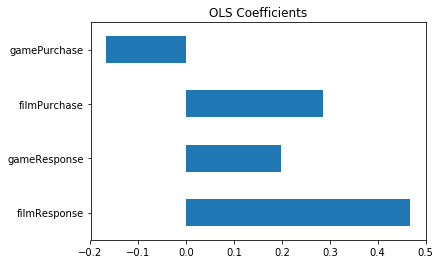

In [165]:
coef = pd.Series(regr.coef_, index = regressionX.columns)

coef.plot(kind = "barh")
plt.title("OLS Coefficients")